In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection, metrics
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
%matplotlib inline

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading data and building features

In [2]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather[item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)


In [3]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [4]:
weather['humidity'] = (weather.DewPoint_x)/(weather.Tavg_x.apply(float))
#weather['yoni_interaction_term_y'] = (weather.DewPoint_y)/(weather.Tavg_y.apply(float))

In [5]:
# Taking derivities of some columns
#weather['tmax_diff'] = weather.Tmax_x.diff()
weather['dewpoint_diff'] = weather.DewPoint_x.diff()
#weather['tmin_diff'] = weather.Tmin_x.diff()
#weather['wetbulb_diff'] = weather.WetBulb_x().apply(float).diff()
weather['precip_diff'] = weather.PrecipTotal_x.apply(float).diff()
weather['tavg_diff'] = weather.Tavg_x.apply(float).diff()

In [6]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

In [7]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [8]:
# This method merges the weather df with a dataframe and does so mulitple times by days for the given amount
# of days
def merge_weather_previous_days(df, days, df_weather = weather):
    for i in range(1, days):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(days=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_day_" + str(i)))
    return df


def merge_weather_previous_weeks(df, weeks, df_weather = weather):
    for i in range(1, weeks):
        date_col = 'Date'+ '_' + str(i)
        if(i == 0):
            date_col = 'Date'
        df[date_col] = df.Date.apply(lambda a: a - pd.Timedelta(weeks=1))
        df = df.merge(weather, left_on=date_col, right_on='Date', suffixes=("","_week_" + str(i)))
    return df


# #This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
# def agg_by_week(df, df_weather = weather):
#     # grouping data in weather column by week and taking the average.
#     # i'm going to use this data to build columns in the passed in data frame that has the average value
#     # of the 
#     agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
#     for d in agg_weather.index:
#         for c in agg_weather:
#             if c not in df.columns:
#                 df[c] = agg_weather.get_value(d, c)
#             for j in range(1, len(df)):
#                 if df.get_value(j, "Date") < d:
#                     if df.get_value(j-1, "Date") > d:
#                         df.set_value(j, c, agg_weather.get_value(d,c))
#                 else:
#                     break
                    
#This method is attempting to take the mean of weather over a weekly period, and append that values to our DF
def agg_by_week(df, df_weather = weather):
    # grouping data in weather column by week and taking the average.
    # i'm going to use this data to build columns in the passed in data frame that has the average value
    # of the 
    for i in range(0, len(df)):
        df_date = df.get_value(i, 'Date')
        agg_weather = df_weather.set_index('Date').groupby(pd.TimeGrouper('W')).mean()
        for c in agg_weather.columns:
            col_name = c+ "_agg"
            if c.startswith('codesum'):
                continue
            if c not in df.columns:
                df[col_name] = -1
            value =  agg_weather[c][(agg_weather.index < df_date) & 
                                (agg_weather.index > df_date - pd.Timedelta(weeks=1))][0]
            #print(value)
            if np.isnan(value):
                value = -1
            df.set_value(i, col_name, value)

In [9]:
# Putting historical weather data onto the data frame
train = merge_weather_previous_days(train, 4, weather)
test =  merge_weather_previous_days(test, 4, weather)

train = merge_weather_previous_weeks(train, 3, weather)
test =  merge_weather_previous_weeks(test, 3, weather)



In [10]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0
        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=time_period):

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):
                    
                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)
                    
                    latdiff = spray_lat - cur_lat
                    longdiff = spray_long - cur_long
                    dis = .5 **(latdiff ** 2 + longdiff ** 2)
                    
                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 15 and cur_lat > spray_lat - 15) and \
                    (cur_long < spray_long + 15 and cur_long > spray_long - 15):
                        data_df.set_value(r,col_name, 1)
                        break

In [11]:
# adding spray data
create_sprayed_cols(train, spray, time_period=2)
create_sprayed_cols(test,spray, time_period=2)

In [13]:
#Convert categorical data to numbers
# lbl = preprocessing.LabelEncoder()
# lbl.fit(list(train['Species'].values) + list(test['Species'].values))
# train['Species'] = lbl.transform(train['Species'].values)
# test['Species'] = lbl.transform(test['Species'].values)

# lbl.fit(list(train['Street'].values) + list(test['Street'].values))
# train['Street'] = lbl.transform(train['Street'].values)
# test['Street'] = lbl.transform(test['Street'].values)

# lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
# train['Trap'] = lbl.transform(train['Trap'].values)
# test['Trap'] = lbl.transform(test['Trap'].values)

#Converting data to catagoreical data. Instead of using the label encoder
train = pd.get_dummies(train, prefix = ['Trap', 'Species', 'Block', 'Street'],\
                                      columns=['Trap','Species','Block','Street'])
test = pd.get_dummies(test, prefix = ['Trap', 'Species','Block','Street'],\
                                     columns=['Trap','Species', 'Block', 'Street'])


In [14]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [15]:
# Making everything numerical if it is a string
train = train.convert_objects(convert_numeric=True)
test = test.convert_objects(convert_numeric=True)

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Converting data to polar coordinates. This may help location become a better predictor.

epicenter_lat = 41.903002
epicenter_long = -87.688267

# epicenter_rho = np.sqrt(epicenter_lat**2 + epicenter_long**2)
# epicenter_phi = np.tan(epicenter_long, epicenter_lat)

train['rho'] = np.sqrt((train['Latitude'] - epicenter_lat)**2 + (train['Longitude'] - epicenter_long)**2)
train['phi'] = np.arctan2((train['Latitude']- epicenter_lat),train['Longitude']- epicenter_long)
test['rho'] = np.sqrt((test['Latitude'] - epicenter_lat)**2 + (test['Longitude'] - epicenter_long)**2)
test['phi'] = np.arctan2((test['Latitude']- epicenter_lat),test['Longitude']- epicenter_long)
train['phi_x_rho'] = train.rho * train.phi
test['phi_x_rho'] = test.rho * test.phi

In [17]:
train = train.drop(train[list(filter(lambda a: a.startswith('Date'), train.columns))], axis=1)
test = test.drop(test[list(filter(lambda a: a.startswith('Date'), test.columns))], axis=1)
train = train.drop(['Latitude', 'Longitude'], axis=1)
test = test.drop(['Latitude', 'Longitude'], axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

## Saving data to CSV to spped up future model building.

In [18]:
train.to_csv('train_w_weather.csv', index=False)
test.to_csv('test_w_weather.csv', index=False)

In [19]:
# train = pd.read_csv('train_w_weather.csv')
# test = pd.read_csv('test_w_weather.csv')

# labels = train.WnvPresent.values

# Grid searching below

In [23]:

features = train.columns
#features = best_features
xgb1 = xgb.XGBClassifier()

parameters = {'nthread':[6], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [2],
              'min_child_weight': [1],
              'silent': [1],
              'subsample': [.91],
              'colsample_bytree': [.58],
              'n_estimators': [1500], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': [1337]}

clf = model_selection.GridSearchCV(xgb1, parameters, n_jobs=6, 
                   cv=model_selection.StratifiedKFold(n_splits=3, random_state=None, shuffle=True
                                                     ), 
                   scoring='roc_auc',
                   verbose=0, refit=True)

clf.fit(train[features], labels)
#model = clf.best_estimator_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=6,
       param_grid={'n_estimators': [1500], 'subsample': [0.91], 'seed': [1337], 'colsample_bytree': [0.58], 'silent': [1], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'nthread': [6], 'min_child_weight': [1], 'max_depth': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [27]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

predictions = clf.predict_proba(test[features])[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)
model = clf.best_estimator_
# sample = pd.read_csv('../input/sample_submission.csv')
# sample.QuoteConversion_Flag = test_probs
# sample.to_csv("xgboost_best_parameter_submission.csv", index=False)



/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


('Raw AUC score:', 0.83521729927491584)
colsample_bytree: 0.58
learning_rate: 0.05
max_depth: 2
min_child_weight: 1
n_estimators: 1500
nthread: 6
objective: 'binary:logistic'
seed: 1337
silent: 1
subsample: 0.91


### Evaluating results

In [ ]:
np.mean(model_selection.cross_val_score(model, X=train, y=labels, scoring='roc_auc', n_jobs=5))

#### Looking at feature importances

Feature ranking:
phi: 0.0584525838494
phi_x_rho: 0.0531166642904
rho: 0.051176328212
Sunrise_x: 0.0317729823291
humidity: 0.0167353861034
ResultSpeed_y: 0.0133398007601
Species_CULEX TERRITANS: 0.0128547176719
year: 0.0123696336523
Sunrise_x_day_2: 0.0109143825248
humidity_week_1: 0.0106718409806
Species_CULEX RESTUANS: 0.0104292994365
AvgSpeed_x_week_1: 0.00945913139731
ResultSpeed_y_week_1: 0.00897404830903
Sunset_x: 0.00873150583357
Species_CULEX SALINARIUS: 0.00848896428943
Block_22: 0.00824642274529
AddressAccuracy: 0.00800388026983
dewpoint_diff: 0.00751879718155
ResultDir_x: 0.00727625517175
DewPoint_x: 0.00727625517175
Block_62: 0.00679117161781
Block_58: 0.00679117161781
Trap_T017: 0.00679117161781
AvgSpeed_y_week_1: 0.00679117161781
Tmin_y_week_1: 0.00654862960801
Species_CULEX PIPIENS: 0.0063060875982
Block_25: 0.00606354605407
Block_30: 0.00582100404426
Trap_T235: 0.00582100404426
Trap_T003: 0.00582100404426
StnPressure_y_week_1: 0.00582100404426
Trap_T090: 0.00557846250013

Trap_T051: 0.0
Trap_T050: 0.0
Trap_T046: 0.0
Trap_T044: 0.0
Trap_T040: 0.0
Trap_T039: 0.0
Trap_T036: 0.0
Trap_T034: 0.0
Trap_T025: 0.0
Trap_T019: 0.0
Trap_T007: 0.0
Trap_T006: 0.0
Trap_T005: 0.0
Trap_T004: 0.0
Trap_T001: 0.0
spray_2011-08-29_2: 0.0
spray_2013-07-17_2: 0.0
GR_y_week_2: 0.0
VCFG_y_week_2: 0.0
SN_y_week_2: 0.0
SQ_y_week_2: 0.0
FG_y_week_2: 0.0
MIFG_y_week_2: 0.0
FG+_y_week_2: 0.0
BCFG_y_week_2: 0.0
DZ_y_week_2: 0.0
TS_y_week_2: 0.0
FU_y_week_2: 0.0
VCTS_y_week_2: 0.0
TSRA_y_week_2: 0.0
RA_y_week_2: 0.0
Heat_y_week_2: 0.0
GR_x_week_2: 0.0
VCFG_x_week_2: 0.0
SN_x_week_2: 0.0
SQ_x_week_2: 0.0
FG_x_week_2: 0.0
MIFG_x_week_2: 0.0
FG+_x_week_2: 0.0
BCFG_x_week_2: 0.0
DZ_x_week_2: 0.0
TS_x_week_2: 0.0
FU_x_week_2: 0.0
VCTS_x_week_2: 0.0
TSRA_x_week_2: 0.0
RA_x_week_2: 0.0
BR_x_week_2: 0.0
ResultSpeed_x_week_2: 0.0
StnPressure_x_week_2: 0.0
SnowFall_x_week_2: 0.0
Depth_x_week_2: 0.0
Sunset_x_week_2: 0.0
Heat_x_week_2: 0.0
GR_y_week_1: 0.0
VCFG_y_week_1: 0.0
SN_y_week_1: 0.0
SQ_y_

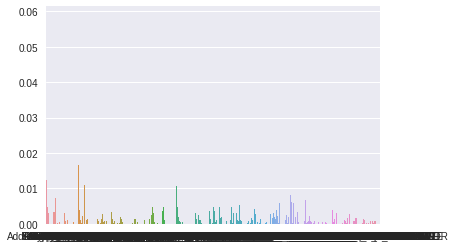

In [79]:
# Zipping feature importances and sorting by how importnat they are
importances = list(zip(train.columns,model.feature_importances_))
#importances = list(zip(best_features,model.feature_importances_))
importances.sort(key=lambda a: a[1])
importances = importances[::-1]
# std = np.std([model.feature_importances_ for tree in model.estimators_],
#              axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(0, len(importances)):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [28]:
best_features = [ x[0] for x in list(filter(lambda a : a[1] >0, importances))]

In [32]:
temp = []
for prefix in ['Trap','Species', 'Block', 'Street']:
    importance = 0
    for i in importances:
        if i[0].startswith(prefix):
            importance += i[1]
    temp.append((prefix, importance))

In [33]:
temp

[('Trap', 0.15648854883329477),
 ('Species', 0.047709923703223467),
 ('Block', 0.086832061628228985),
 ('Street', 0.060353053486323915)]

In [38]:
importances = importances + temp

In [39]:
importances.sort(key=lambda a: a[1])
importances = importances[::-1]


In [80]:
names = zip(*importances)[0]
values = zip(*importances)[1]

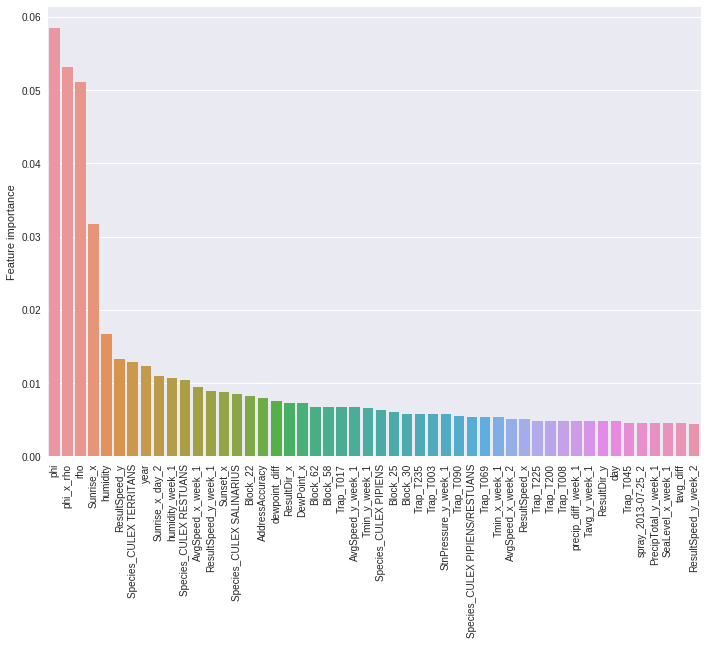

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
features = sns.barplot(x=list(names)[0:50], y=list(values)[0:50])
features.set_ylabel('Feature importance')
_= plt.setp(features.get_xticklabels(), rotation=90)

In [64]:
t = list(values)

In [65]:
t = t[0:40]
t.append(sum(list(values)[40::]))

In [78]:
zip(x,t)

[('Trap', 0.15648854883329477),
 ('Block', 0.086832061628228985),
 ('phi', 0.0615458),
 ('Street', 0.060353053486323915),
 ('phi_x_rho', 0.059398856),
 ('rho', 0.052480917),
 ('Species', 0.047709923703223467),
 ('Sunrise_x', 0.029818702),
 ('humidity', 0.015744274),
 ('Species_CULEX RESTUANS', 0.012881679),
 ('ResultSpeed_y', 0.012404581),
 ('year', 0.012166031),
 ('Species_CULEX TERRITANS', 0.011211832),
 ('Sunrise_x_day_2', 0.0095419846),
 ('dewpoint_diff', 0.0093034348),
 ('humidity_week_1', 0.0090648858),
 ('AvgSpeed_x_week_1', 0.0088263359),
 ('Species_CULEX PIPIENS', 0.008587786),
 ('ResultSpeed_y_week_1', 0.008587786),
 ('AvgSpeed_y_week_1', 0.008349237),
 ('Sunset_x', 0.008349237),
 ('Species_CULEX SALINARIUS', 0.0076335878),
 ('Block_22', 0.0073950384),
 ('Species_CULEX PIPIENS/RESTUANS', 0.0073950384),
 ('DewPoint_x', 0.0073950384),
 ('day', 0.0071564885),
 ('Tmax_x_week_1', 0.0069179391),
 ('ResultSpeed_x', 0.0069179391),
 ('Block_58', 0.0064408397),
 ('Tmin_y_week_1', 0.006

In [73]:
x = list(names)[0:50]+['Remainder']

In [74]:
x

['Trap',
 'Block',
 'phi',
 'Street',
 'phi_x_rho',
 'rho',
 'Species',
 'Sunrise_x',
 'humidity',
 'Species_CULEX RESTUANS',
 'ResultSpeed_y',
 'year',
 'Species_CULEX TERRITANS',
 'Sunrise_x_day_2',
 'dewpoint_diff',
 'humidity_week_1',
 'AvgSpeed_x_week_1',
 'Species_CULEX PIPIENS',
 'ResultSpeed_y_week_1',
 'AvgSpeed_y_week_1',
 'Sunset_x',
 'Species_CULEX SALINARIUS',
 'Block_22',
 'Species_CULEX PIPIENS/RESTUANS',
 'DewPoint_x',
 'day',
 'Tmax_x_week_1',
 'ResultSpeed_x',
 'Block_58',
 'Tmin_y_week_1',
 'ResultSpeed_x_week_1',
 'StnPressure_y_week_1',
 'ResultDir_x',
 'Trap_T090',
 'Trap_T103',
 'Trap_T082',
 'dewpoint_diff_week_1',
 'PrecipTotal_y_week_1',
 'humidity_day_2',
 'Trap_T235',
 'Trap_T017',
 'Trap_T008',
 'Tmin_x_week_1',
 'Block_62',
 'Block_25',
 'Trap_T228',
 'Trap_T003',
 'humidity_week_2',
 'AvgSpeed_x_week_2',
 'ResultDir_y_week_1',
 'Remainder']